In [116]:
#!/usr/bin/env python3
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_cdr, ros1_to_cdr
from rosbags.typesys import get_types_from_msg, register_types
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [117]:
add_types = {}
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Marker.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Marker'))
register_types(add_types)
msg_text = Path('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/vicon_bridge/msg/Markers.msg').read_text()
add_types.update(get_types_from_msg(msg_text, 'vicon_bridge/Markers'))
register_types(add_types)

In [130]:
t_count = 0
marker_pos = {t_count:[]}
prev_t = False
# with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_1.bag') as reader:
with Reader('/home/eurus/Documents/College/Sem_4/ENAE788M/proj/ws/src/Project_Catch/misc/marker_throw/throw_2.bag') as reader:
    for connection, timestamp, rawdata in reader.messages():
        ## The local position message from the PX4
        if connection.topic == '/vicon/markers':
            msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
            if(len(msg.markers)):
                prev_t = True
                if(t_count not in marker_pos):
                    marker_pos[t_count] = []
                marker_pos[t_count].append([msg.markers[0].translation.x, msg.markers[0].translation.y, msg.markers[0].translation.z,msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9])
            else:
                if(prev_t):
                    prev_t = False
                    if(len(marker_pos[t_count])<50):
                        marker_pos[t_count] = []
                    else:
                        marker_pos[t_count] = np.array(marker_pos[t_count])
                        t_count += 1
                    

In [131]:
throw_ = 1
marker_pos[throw_][1:,-1] -= marker_pos[throw_][:-1,-1]
marker_pos[throw_][0,-1] = 0

In [132]:
# for i in range(0, len(marker_pos)):
#     marker_ = np.array(marker_pos[i])
#     marker_[:,-1] = marker_[:,-1] - marker_[0,-1]
#     plt.scatter(marker_[:,-1], marker_[:,2])
#     plt.title('Marker Z Position vs Time Index: '+str(i))
#     plt.pause(0.1)

# Kalman Filter 3D parabola fit

In [133]:
class KalmanFilter3D:
    def __init__(self):
        # Kalman Filter
        # State Vector
        ## x y z az vx vy vz ax ay 
        self.state = np.zeros((9,1))

        # Measurement Matrix
        ## Defines which states are measured
        ## Only position is measured, x y z az
        self.H = np.array([[1,0,0,0,0,0,0,0,0],
                    [0,1,0,0,0,0,0,0,0],
                    [0,0,1,0,0,0,0,0,0],
                    [0,0,0,1,0,0,0,0,0],
                    ])


        # Covariance Matrix
        ## Defines how much we trust the model 
        self.R = np.array([[0.01,0,0,0],
                    [0,0.01,0,0],
                    [0,0,0.01,0],
                    [0,0,0,0.01],
                    ])


        # Process Noise Covariance Matrix
        ## Defines the noise relationship between states
        self.Q = np.array([[0.01,0,0,0,0,0,0,0,0],
                    [0,0.01,0,0,0,0,0,0,0],
                    [0,0,0.01,0,0,0,0,0,0],
                    [0,0,0,0.01,0,0,0,0,0],
                    [0,0,0,0,0.01,0,0,0,0],
                    [0,0,0,0,0,0.01,0,0,0],
                    [0,0,0,0,0,0,0.01,0,0],
                    [0,0,0,0,0,0,0,0.01,0],
                    [0,0,0,0,0,0,0,0,0.01],
                    ])

        self.state_est = np.zeros((9,1))
        self.P_est = np.eye(9)
        
        # Gravity along the Z axis
        self.gravity = -9.81
        
    def update(self, dt, measurement):
        
        # State Prediction
        self.state_predict(dt)
        
        # Measurement Update
        
        # Update the Kalman Gain
        ## Update the Kalman Gain based on the covariance and measurement matrix
        self.K = np.dot(self.P_est, np.dot(self.H.T, np.linalg.inv(self.H @ self.P_est @ self.H.T + self.R)))
        
        measurement = np.vstack((measurement.reshape(3,1), np.ones((1,1))*self.gravity))
        # Update the state estimation using the Kalman Gain
        self.state_est = self.state + np.dot(self.K, measurement - self.H @ self.state)
        
        # Update the covariance matrix
        self.P = np.dot((np.eye(9) - np.dot(self.K, self.H)), self.P_est)
        pass
    
    def state_predict(self, dt):
        #######
        # State Transition Matrix
        ## Defines states are dependent on previous states
        ## The lines are equation of motion s = s0 + v0*t + 0.5*a*t^2
        A = np.array([[1,0,0,0,dt,0,0,0.5*dt**2,0],
                      [0,1,0,0,0,dt,0,0,0.5*dt**2],
                      [0,0,1,0.5*dt**2,0,0,dt,0,0],
                      [0,0,0,1,0,0,0,0,0],
                      [0,0,0,0,1,0,0,dt,0],
                      [0,0,0,0,0,1,0,0,dt],
                      [0,0,0,dt,0,0,1,0,0],
                      [0,0,0,0,0,0,0,1,0],
                      [0,0,0,0,0,0,0,0,1],
                    ])
        ########
        
        # State Update
        ## Predict next state based on state transition matrix
        self.state = np.dot(A,self.state_est)
        
        # Covariance Update
        ## Update the covariance of the model based on the previous state and process noise
        self.P = np.dot(np.dot(A,self.P_est),A.T) + self.Q

        

In [134]:
ekf = KalmanFilter3D()
lim = 50
kalman_points = []
for wp, marker_ in enumerate(marker_pos[throw_][:,:]):
    # print(marker_)
    if(wp < lim):
        ekf.update(marker_[-1], marker_[:3])
    else:
        ekf.state_predict(marker_[-1])
        ekf.state_est = ekf.state
        kalman_points.append(ekf.state_est[:3].reshape(3))      
kalman_points =np.array(kalman_points)

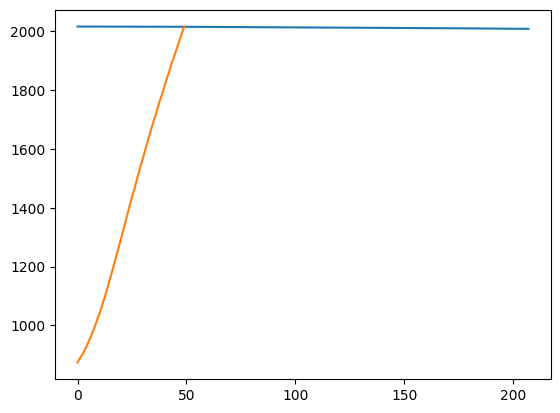

In [135]:
axis = 2
plt.plot(kalman_points[:,axis])
plt.plot(marker_pos[throw_][:lim,axis])